# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
  
  Sunday, 31 May 2019, 9:00 - 2:00  Hotel Flora  
  
  
**Convenors**
* [Dr Chelle Gentemann](mailto:gentemann@esr.org)    - Earth and Space Research, USA
* [Dr Marisol Garcia-Reyes](mailto:marisolgr@faralloninstitute.org)  - Farallon Institute, USA 
-------------


# With

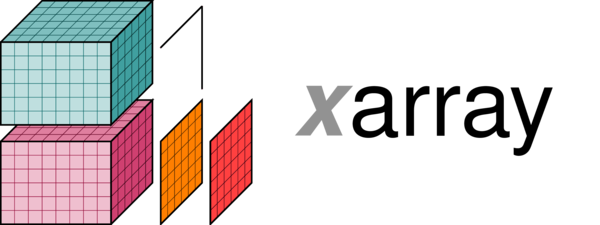

# you can reach

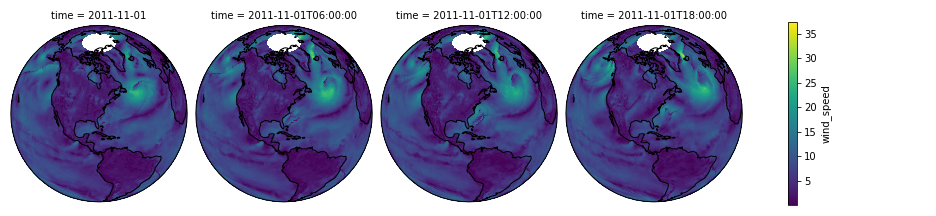

# Structure of this tutorial

1. Opening data
3. Advanced data plotting and exploration
4. Collocating satellite data with a cruise dataset



# 1. Key features of `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot and xarray

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import s3fs

def get_key(file_name):
    myvars = {}
    with open(file_name) as myfile:
        for line in myfile:
            name, var = line.partition("=")[::2]
            myvars[name.strip()] = str(var).rstrip()
    return myvars


## Let's open a wind speed
Below, let's open CCMP winds for the same day using xarray.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.

Then just print out the file details by just typing the dataset name, ds_ccmp

In [2]:
#ds_ccmp = ds_ccmp.where(ds_ccmp.sst>-1000.0,np.nan)
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/2011/11/analysis_20111101_v11l30flk.nc.gz'
ds_ccmp = xr.open_dataset(url)
ds_ccmp

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time     (time) datetime64[ns] 2011-11-01 ... 2011-11-01T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 ...
    vwnd     (time, lat, lon) float32 ...
    nobs     (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    title:                           Atlas FLK v1.1 derived surface winds (le...
    description:                     VAM 6-hour analyses starting from the EC...
    history:                         Created by NASA Goddard Space Flight Cen...
    base_date:                       [2011   11    1]
    DODS_EXTRA.Unlimited_Dimension:  time

## If you look at the time values you can see that the dataset is at :00, :06, :12, :18

* If you look at the lon values you can see that this dataset is 0-360 rather than -180-180, 

*  let's change the longitude coordinates using [.coords](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coords.html) and then [.sortby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sortby.html) |

## To get from 0-360 to -180-180
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180  
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## To get from -180-180 to 0-360
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp['lon'], 360)
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## Okay, try going from 0-360 to -180-180 below and then print out the dataset

In [3]:
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
ds_ccmp['wind_speed'] = np.sqrt(ds_ccmp.uwnd**2 + ds_ccmp.vwnd**2)
ds_ccmp['wind_dir'] = np.arctan2(ds_ccmp.vwnd,ds_ccmp.uwnd)/np.pi*180
ds_ccmp

<xarray.Dataset>
Dimensions:     (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon         (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat         (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time        (time) datetime64[ns] 2011-11-01 ... 2011-11-01T18:00:00
Data variables:
    uwnd        (time, lat, lon) float32 -1.9379845 -2.0539584 ... 7.2849903
    vwnd        (time, lat, lon) float32 6.0886283 5.9818106 ... -6.113044
    nobs        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wind_speed  (time, lat, lon) float32 6.389615 6.324619 ... 9.737151 9.510015
    wind_dir    (time, lat, lon) float32 107.65605 108.95079 ... -40.000973
Attributes:
    Conventions:                     COARDS
    title:                           Atlas FLK v1.1 derived surface winds (le...
    description:                     VAM 6-hour analyses starting from the EC...
    history:                         Created by NASA Goddard Space Fli

## Now look at your dataset, both are -180 to 180!


# 5. Graphics 

``xarray`` plotting functions rely on matplotlib internally, but they make use of all available metadata to make the plotting operations more intuitive and interpretable.  Plotting examples are given [here](http://xarray.pydata.org/en/stable/plotting.html)

# Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2)`

* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument

* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next

* Change the number of bins using an argument in hist eg.  `bins=20`

* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`


(array([1.03171739e-05, 2.36516345e-05, 4.77899282e-05, 1.42007234e-04,
        2.96570084e-04, 7.30378047e-04, 2.51437315e-03, 6.06708225e-03,
        1.47230963e-02, 2.58877403e-02, 4.97094134e-02, 8.49620387e-02,
        8.05006389e-02, 5.10756561e-02, 2.20052666e-02, 8.88075375e-03,
        3.15432992e-03, 9.78477209e-04, 3.19151068e-04, 4.77899282e-05]),
 array([-33.406578 , -30.566286 , -27.725994 , -24.885702 , -22.045412 ,
        -19.20512  , -16.364828 , -13.524536 , -10.684244 ,  -7.8439527,
         -5.003661 ,  -2.1633694,   0.6769222,   3.5172138,   6.357506 ,
          9.197798 ,  12.038089 ,  14.878381 ,  17.718672 ,  20.558964 ,
         23.399256 ], dtype=float32),
 <a list of 1 Patch objects>)

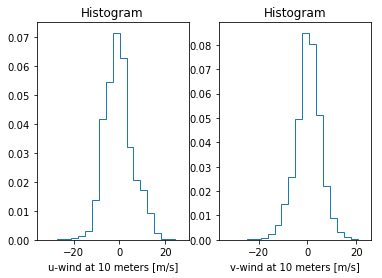

In [4]:
fig, axes = plt.subplots(ncols=2)
ds_ccmp.uwnd.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
ds_ccmp.vwnd.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')

## facet plot allows to do multiplot with the same color mappings

To make a facet plot, use `.plot.contourf` and set your `x`, `y`, `col` values  (eg. 'lat' 'lon' 'time')

You also want `col_wrap=2` and `levels=22`

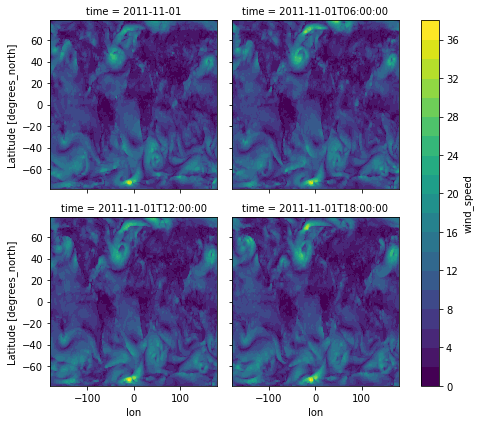

In [5]:
ds_ccmp.wind_speed.plot.contourf(x='lon', y='lat', col='time', col_wrap=2, levels=22);

### Plotting on maps

For plotting on maps, we rely on the excellent [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) library.

In [6]:
import cartopy.crs as ccrs

## In cartopy you need to define the map projection you want to plot.  

Common ones are Ortographic and PlateCarree.
So, use ax = plt.axes(set your projection here)

This creates an empty plot on axes = ax

We now plot the data onto ax and use the key transform = to tell the projection that the data is stored in

You can add coastlines and gridlines to the axes as well.

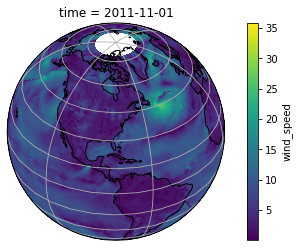

In [7]:
f = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ds_ccmp.wind_speed[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(); 

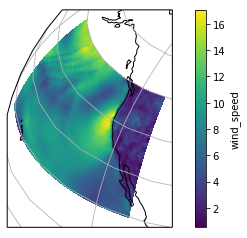

In [8]:
subset = ds_ccmp.sel(lat=slice(20,50),lon=slice(-170,-110)).mean('time')
f = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
subset.wind_speed.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(); 


(20, 50)

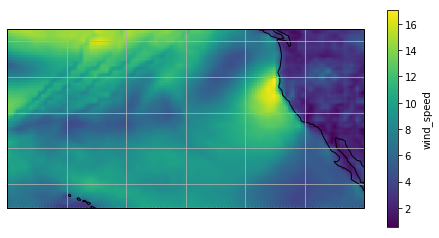

In [9]:
subset = ds_ccmp.sel(lat=slice(20,50),lon=slice(-170,-110)).mean('time')
f = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
subset.wind_speed.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(); 
ax.set_xlim(-170,-110); ax.set_ylim(20,50)


#### Facet plots on maps

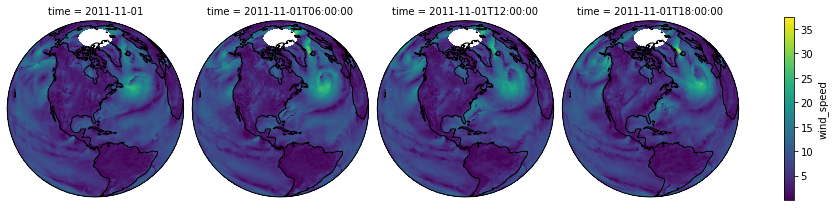

In [10]:
p = ds_ccmp.wind_speed.plot(x='lon', y='lat', col='time', transform=ccrs.PlateCarree(),
                  subplot_kws={'projection': ccrs.Orthographic(-80, 35)})
for ax in p.axes.flat:
    ax.coastlines()
#fig_fname='./images/ccmp_6hourly.png'
#p.fig.savefig(fig_fname, transparent=False, format='png')

## There is no land mask in CCMP data, so just to demonstrate how to get a nice land mask, use .where and ds_ccmp.nobs to set data over land to NaN.  The xarray function .where(cond,other) the argument other is a value that is set when cond=False


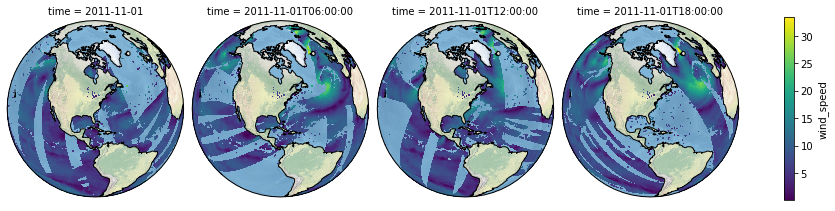

In [11]:
ds_ccmp_ocn = ds_ccmp.where(ds_ccmp.nobs>0,np.nan)
p = ds_ccmp_ocn.wind_speed.plot(x='lon', y='lat', col='time', transform=ccrs.PlateCarree(),
                  subplot_kws={'projection': ccrs.Orthographic(-80, 35)})
for ax in p.axes.flat:
    ax.coastlines()
    ax.stock_img();

## A nice cartopy tutorial is [here](http://earthpy.org/tag/visualization.html)

# 6. Collocate a Saildrone cruise with MUR SST data

### Let's open 2 months of 0.2 km AVHRR OI SST data

`xarray`can open multiple files at once using string pattern matching.  
  
  In this case we open all the files that match our `filestr`, i.e. all the files for the 2080s. 
  
  Each of these files (compressed) is approximately 800 MB.

In [12]:
from glob import glob
filepath = '../GHRSST_tutorial/data/avhrr_oi/*.nc'
files = glob(filepath,recursive=True)
files[:10]

['../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180410.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180411.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180412.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180413.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180414.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180415.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180416.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180417.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180418.nc',
 '../GHRSST_tutorial/data/avhrr_oi\\avhrr-only-v2.20180419.nc']

# Let's see what one day looks like

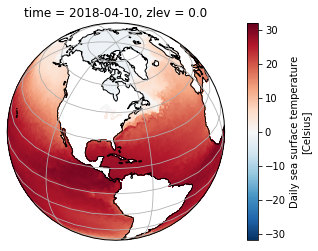

In [13]:
ds_sst = xr.open_dataset(files[0])
f = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ds_sst.sst[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(); 

# Change the colormap, colorscale, and add land

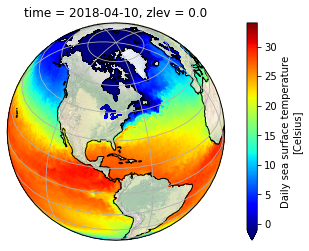

In [14]:
f = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ds_sst.sst[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(),cmap='jet',vmin=-1,vmax=34)
ax.coastlines(); ax.gridlines();
ax.stock_img();
#fig_fname='./images/sst_avhrroi.png'
#f.savefig(fig_fname, transparent=False, format='png')

## Now open MUR zarr data stored on S3 bucket

* use credentials, here stored in aimee_key.txt

In [15]:
myvars = get_key("C:/Users/gentemann/Google Drive/f_drive/aimee_key.txt")

s3 = s3fs.S3FileSystem(anon=False, key=myvars["key"], secret=myvars["secret"])
store = s3fs.S3Map(root='ds-data-projects/mur_sst/zarr/test-chunking-5vars-60days/1x1000x1000', s3=s3, check=False)
ds_sst = xr.open_zarr(store)


# Collocating Saildrone cruise data with MUR SSTs 

* read in the Saildrone data 

In [16]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(url)
ds_usv

<xarray.Dataset>
Dimensions:               (obs: 86839, trajectory: 1)
Coordinates:
  * trajectory            (trajectory) float32 1002.0
    time                  (trajectory, obs) datetime64[ns] ...
    latitude              (trajectory, obs) float64 ...
    longitude             (trajectory, obs) float64 ...
Dimensions without coordinates: obs
Data variables:
    SOG                   (trajectory, obs) float64 ...
    COG                   (trajectory, obs) float64 ...
    HDG                   (trajectory, obs) float64 ...
    HDG_WING              (trajectory, obs) float64 ...
    ROLL                  (trajectory, obs) float64 ...
    PITCH                 (trajectory, obs) float64 ...
    WING_ANGLE            (trajectory, obs) float64 ...
    BARO_PRES_MEAN        (trajectory, obs) float64 ...
    BARO_PRES_STDDEV      (trajectory, obs) float64 ...
    TEMP_AIR_MEAN         (trajectory, obs) float64 ...
    TEMP_AIR_STDDEV       (trajectory, obs) float64 ...
    RH_MEAN        

## The NCEI trajectory format uses 'obs' as the coordinate.  This is an example of an 'older' style of data formatting that doesn't really mesh well with modern software capabilities. 

* So, let's change that by using [.swap_dims](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.swap_dims.html) to change the coordinate from `obs` to `time`
* Another thing, `latitude` and `longitude` are just long and annoying, lets [.rename](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html) them to `lat` and `lon`

* Finally, the first and last part of the cruise the USV is being towed, so let's only include data from `2018-04-12T02` to `2018-06-10T18`


In [17]:
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv_subset = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) 

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons
    * Find the max/min of the lat/lon using `.lon.min().data`

1. Now load the data into memory (de-Dask-ify) it using `.load()`  


In [18]:
#Step 1 from above
print('min max lat lon:', ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data,ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data)
subset = ds_sst.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
subset.load()

min max lat lon: -125.55297279999999 -115.5226624 28.0176832 37.6797408


<xarray.Dataset>
Dimensions:       (lat: 966, lon: 1003, time: 60)
Coordinates:
  * lat           (lat) float32 28.02 28.03 28.04 28.05 ... 37.65 37.66 37.67
  * lon           (lon) float32 -125.55 -125.54 -125.53 ... -115.54 -115.53
  * time          (time) datetime64[ns] 2018-04-12T09:00:00 ... 2018-06-10T09:00:00
Data variables:
    analysed_sst  (time, lat, lon) float32 291.72998 291.722 291.715 ... nan nan
    mask          (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
Attributes:
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    creator_url:                http://mur.jpl.nasa.gov
    date_created:               

# Collocate USV data with MUR data
There are different options when you interpolate.  First, let's just do a linear interpolation using [.interp()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp)

`Dataset.interp(coords=None, method='linear', assume_sorted=False, kwargs={}, **coords_kwargs))`



In [19]:
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')

# Collocate USV data with MUR data
There are different options when you interpolate.  First, let's just do a nearest point rather than interpolate the data
`method = 'nearest'`

In [20]:
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

## Now, calculate the different in SSTs and print the [.mean()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean) and [.std()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html#xarray.DataArray.std)
For the satellite data we need to use `sst` and for the USV data we need to use `TEMP_CTD_MEAN`

In [21]:
dif = ds_collocated_nearest.analysed_sst-273.15-ds_usv.TEMP_CTD_MEAN
print('mean difference = ',dif.mean().data)
print('STD = ',dif.std().data)

mean difference =  0.330862216985714
STD =  0.4153290009981746


# xarray can do more!

* concatentaion
* open network located files with openDAP
* import and export Pandas DataFrames
* .nc dump to 
* groupby_bins
* resampling and reduction

For more details, read this blog post: http://continuum.io/blog/xray-dask


In [22]:
#ds_collocated_nearest.to_netcdf('./data/new file.nc')

## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences

For analyzing GCM output:

- [xgcm](https://github.com/xgcm/xgcm) by Ryan Abernathey
- [oogcm](https://github.com/lesommer/oocgcm) by Julien Le Sommer
- [MPAS xarray](https://github.com/pwolfram/mpas_xarray) by Phil Wolfram
- [marc_analysis](https://github.com/darothen/marc_analysis) by Daniel Rothenberg

Other tools:

- [windspharm](https://github.com/ajdawson/windspharm): wind spherical harmonics by Andrew Dawson
- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray
